In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (18,12)
mpl.rcParams['axes.grid'] = False
sns.set_style('whitegrid')

import torch
import torch.nn as nn

In [34]:
# Upload the data frame into the notebook
data_frame = pd.read_csv('Data/learn_noise_siso2_2.csv', usecols=["Y","U"])
test_frame = pd.read_csv('Data/learn_noise_siso2_2.csv', usecols=["Y","U"])
prediction_test_frame = pd.read_csv('Data/learn_noise_siso2_2.csv', nrows=6, usecols=["Y","U"])

In [35]:
display(data_frame.head(5))

,Y,U
0,0.000000,-0.195928
1,0.000000,-0.103006
2,0.000000,0.000000
3,0.103006,0.103006
4,0.195928,0.195928


In [36]:
# Defining a batch size based on the data
batch_size = 100

# Split the dataset into different batches
batch_data = np.array_split(data_frame, int(data_frame.shape[0]/batch_size))

# Shifting batch number 5 to the end to be used as a test data
# batch_data.append(batch_data.pop(1))

# Combining all the batches to form a single dataset
df = pd.DataFrame(np.concatenate(batch_data),columns=list(data_frame.columns))

In [37]:
batch_data

[           Y         U
 0   0.000000 -0.195928
 1   0.000000 -0.103006
 2   0.000000  0.000000
 3   0.103006  0.103006
 4   0.195928  0.195928
 ..       ...       ...
 95 -0.065787 -0.269672
 96 -0.388069 -0.317019
 97 -0.319085 -0.333333
 98 -0.296178 -0.317019
 99 -0.237074 -0.269672
 
 [100 rows x 2 columns],
             Y             U
 100 -0.134495 -1.959284e-01
 101  0.036749 -1.030057e-01
 102 -0.078202 -4.082156e-16
 103  0.068360  1.030057e-01
 104  0.105919  1.959284e-01
 ..        ...           ...
 195 -0.065787 -2.696723e-01
 196 -0.388069 -3.170188e-01
 197 -0.319085 -3.333333e-01
 198 -0.296178 -3.170188e-01
 199 -0.237074 -2.696723e-01
 
 [100 rows x 2 columns],
             Y             U
 200 -0.134495 -1.959284e-01
 201  0.036749 -1.030057e-01
 202 -0.078202 -8.164312e-16
 203  0.068360  1.030057e-01
 204  0.105919  1.959284e-01
 ..        ...           ...
 295 -0.065787 -2.696723e-01
 296 -0.388069 -3.170188e-01
 297 -0.319085 -3.333333e-01
 298 -0.296178 -3.17

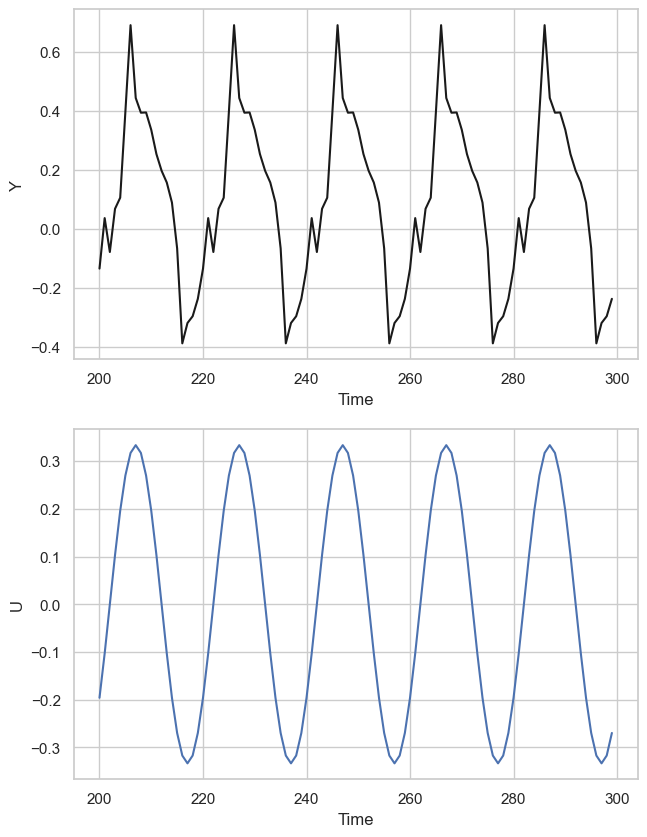

In [38]:
# Plotting the test data batch
fig = plt.figure(figsize=(16,10))

batch_no = 3

plt.subplot(2, 2, 1)
plt.plot(batch_data[batch_no-1]['Y'],'k')
plt.xlabel('Time')
plt.ylabel('Y')


plt.subplot(2, 2, 3)
plt.plot(batch_data[batch_no-1]['U'],'b')
plt.xlabel('Time')
plt.ylabel('U')


plt.show()

In [39]:
# Define a test size
test_size = batch_size

y = df.values.astype(float)
y_test = test_frame.values.astype(float)
y_pred_test = prediction_test_frame.values.astype(float)

# Create train and test sets
train_set = y
test_set = y_test
pred_test_set = y_pred_test
print(test_set)
# Convert train set into a torch tensor
train_set = torch.FloatTensor(train_set).view(-1,df.shape[1])
test_set = torch.FloatTensor(test_set).view(-1,df.shape[1])
pred_test_set= torch.FloatTensor(pred_test_set).view(-1,df.shape[1])

[[ 0.         -0.19592842]
 [ 0.         -0.10300566]
 [ 0.          0.        ]
 ...
 [-0.31908546 -0.33333333]
 [-0.29617755 -0.31701884]
 [-0.2370737  -0.26967233]]


In [40]:
# Creating a function to generate the input data for the lstm 
def input_data(seq,ws):
    
    inp_data = []
    
    for bat in range(0,train_set.shape[0],batch_size):
        
        bat_seq = seq[bat:bat+101]
        l = len(bat_seq)
        
        window = []
        label = []
        
        for i in range(l-ws):
        
            window = bat_seq[i:i+ws]
            label = bat_seq[i+ws:i+ws+1,:2]

            inp_data.append((window,label))
        
    return inp_data

In [41]:
# Defining a window size for prediction
window_size = 1
train_data = input_data(train_set,window_size)

print(train_data)

[(tensor([[ 0.0000, -0.1959]]), tensor([[ 0.0000, -0.1030]])), (tensor([[ 0.0000, -0.1030]]), tensor([[0., 0.]])), (tensor([[0., 0.]]), tensor([[0.1030, 0.1030]])), (tensor([[0.1030, 0.1030]]), tensor([[0.1959, 0.1959]])), (tensor([[0.1959, 0.1959]]), tensor([[0.5610, 0.2697]])), (tensor([[0.5610, 0.2697]]), tensor([[0.5493, 0.3170]])), (tensor([[0.5493, 0.3170]]), tensor([[0.4197, 0.3333]])), (tensor([[0.4197, 0.3333]]), tensor([[0.4164, 0.3170]])), (tensor([[0.4164, 0.3170]]), tensor([[0.3988, 0.2697]])), (tensor([[0.3988, 0.2697]]), tensor([[0.3286, 0.1959]])), (tensor([[0.3286, 0.1959]]), tensor([[0.2542, 0.1030]])), (tensor([[0.2542, 0.1030]]), tensor([[2.0087e-01, 4.0822e-17]])), (tensor([[2.0087e-01, 4.0822e-17]]), tensor([[ 0.1562, -0.1030]])), (tensor([[ 0.1562, -0.1030]]), tensor([[ 0.0884, -0.1959]])), (tensor([[ 0.0884, -0.1959]]), tensor([[-0.0683, -0.2697]])), (tensor([[-0.0683, -0.2697]]), tensor([[-0.3893, -0.3170]])), (tensor([[-0.3893, -0.3170]]), tensor([[-0.3197, -0

In [10]:
# from classy import LSTMModel
from classy import LSTMModel
# Creating a model instance, loss function and the optimizer

model = LSTMModel(2, 100, out_size=1, num_layers=4)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [11]:
display(model)

LSTMModel(
  (lstm_1): LSTM(2, 100, num_layers=4)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [12]:
display(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [13]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

   800
 40000
   400
   400
 40000
 40000
   400
   400
 40000
 40000
   400
   400
 40000
 40000
   400
   400
   100
     1
______
284101


In [14]:
display(model)

LSTMModel(
  (lstm_1): LSTM(2, 100, num_layers=4)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [45]:
# Set the number of epochs

epochs = 50
hidden=model.init_hidden(batch_size=1)

for epoch in range(epochs):
    
    # Running each batch separately 
    
    for bat in range(0,1400,100):

        for seq,label in train_data[bat:bat+100]:
            
            # set the optimization gradient to zero

            optimizer.zero_grad()
            # Make predictions on the current sequence

            y_pred = model(seq, hidden)  
            
            # Compute the loss

            loss = criterion(y_pred, label)
            
            # Perform back propogation and gradient descent
            loss.backward()

            optimizer.step()
        
        model.init_hidden(1)


                      


    if epoch%10 == 0:

        print(f'Epoch: {epoch} Loss: {loss.item():10.8f}')

learnt_hidden=hidden

c:\Users\jacek\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0 Loss: 0.00102897
Epoch: 10 Loss: 0.00094364
Epoch: 20 Loss: 0.00098766
Epoch: 30 Loss: 0.00098597
Epoch: 40 Loss: 0.00096686


In [46]:
future = 100

# Set the model to evaluation mode

model.eval()
preds = [test_set[0,:1].reshape(-1,1)]
print(test_set[0,:1])
print(preds)
for i in range(future-1):
    
    seq = test_set[i].reshape(-1,2)
    
    # Informing PyTorch that I am no longer interested in the gradients
    
    with torch.no_grad():
        pred = model(seq, hidden)
        preds.append(pred)

        
print(preds)       

tensor([0.])
[tensor([[0.]])]
[tensor([[0.]]), tensor([[-0.0546]]), tensor([[0.0124]]), tensor([[0.0851]]), tensor([[0.1601]]), tensor([[0.3224]]), tensor([[0.3605]]), tensor([[0.3365]]), tensor([[0.3204]]), tensor([[0.3208]]), tensor([[0.3202]]), tensor([[0.3175]]), tensor([[0.1046]]), tensor([[0.0203]]), tensor([[-0.0509]]), tensor([[-0.1614]]), tensor([[-0.3512]]), tensor([[-0.3279]]), tensor([[-0.3042]]), tensor([[-0.2684]]), tensor([[-0.1615]]), tensor([[-0.0298]]), tensor([[-0.0234]]), tensor([[0.0603]]), tensor([[0.0836]]), tensor([[0.3125]]), tensor([[0.3198]]), tensor([[0.3634]]), tensor([[0.3260]]), tensor([[0.3140]]), tensor([[0.3191]]), tensor([[0.3229]]), tensor([[0.1049]]), tensor([[0.0204]]), tensor([[-0.0513]]), tensor([[-0.1619]]), tensor([[-0.3519]]), tensor([[-0.3279]]), tensor([[-0.3040]]), tensor([[-0.2680]]), tensor([[-0.1615]]), tensor([[-0.0298]]), tensor([[-0.0235]]), tensor([[0.0602]]), tensor([[0.0835]]), tensor([[0.3125]]), tensor([[0.3198]]), tensor([[0.363

In [47]:
predictions = np.array([pred.numpy() for pred in preds]).reshape(-1,1)
true_values = np.array(test_set[:,:1])

Text(0, 0.5, 'x1')

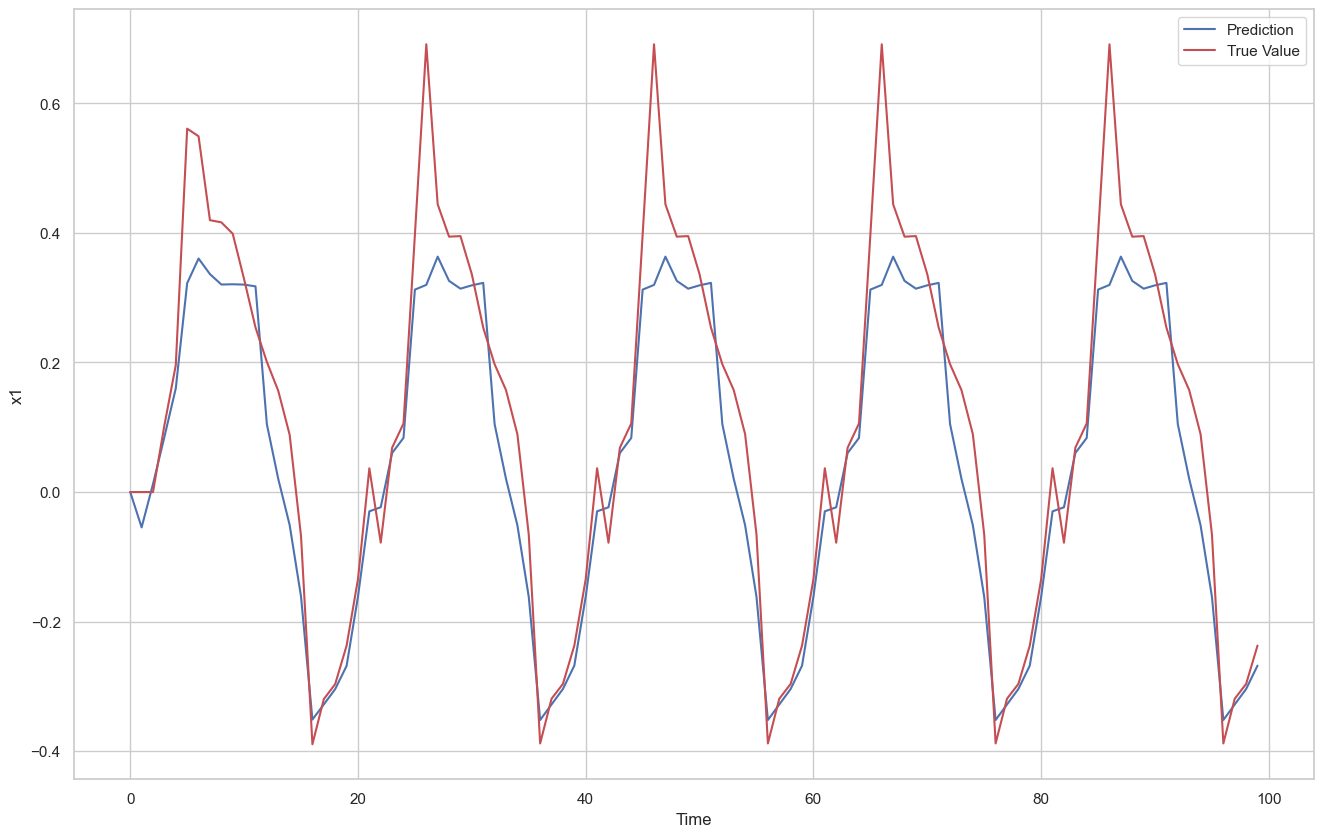

In [48]:
fig = plt.figure(figsize=(16,10))

plt.plot(predictions[:100,0],'b',label='Prediction')
plt.plot(true_values[:100,0],'r',label='True Value')
plt.legend()
plt.xlabel('Time')
plt.ylabel('x1')

In [49]:
RMSE = np.sqrt(np.sum(np.square((predictions - true_values[:,0])))/predictions.size)
display(RMSE)

14.657727803960611

In [50]:
future=100
hidden=learnt_hidden
preds = [test_set[0,:1].reshape(-1,1)]
print(test_set[0,:1])
print(preds)

for i in range(future-1):
    if i < len(pred_test_set):
        seq = test_set[i].reshape(-1, 2)
    else:
        x = torch.FloatTensor(preds[-1])  # Assuming preds[-1] contains the last prediction
        y = 1.0
        seq = torch.FloatTensor([x, y]).view(-1, df.shape[1])
            
    # Check if the sequence length is greater than 0
    if seq.size(0) > 0:
        # Informing PyTorch that I am no longer interested in the gradients
        with torch.no_grad():
            pred = model(seq, hidden)
            preds.append(pred)
            


tensor([0.])
[tensor([[0.]])]


In [51]:
predictions2 = np.array([pred.numpy() for pred in preds]).reshape(-1,1)
true_values = np.array(test_set[:,:1])

Text(0, 0.5, 'x1')

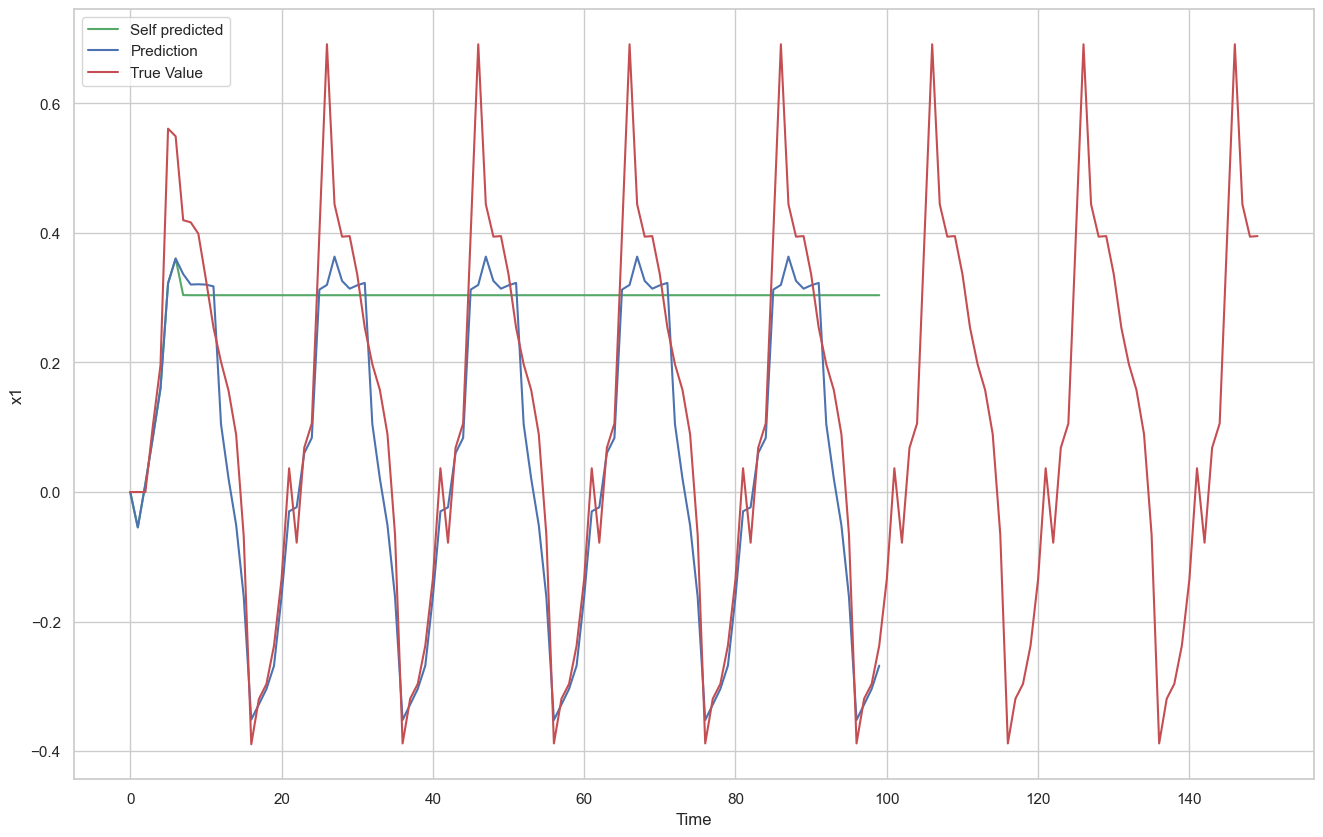

In [52]:
fig = plt.figure(figsize=(16,10))
plt.plot(predictions2[:150,0],'g',label='Self predicted')
plt.plot(predictions[:150,0],'b',label='Prediction')
plt.plot(true_values[:150,0],'r',label='True Value')
plt.legend()
plt.xlabel('Time')
plt.ylabel('x1')